In [1]:
import numpy as np
from numpy.random import random, choice
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(1, '/Users/richard/Documents/projects/py_learning/sussex/Dissertation/gym')

import gym

In [2]:
env = gym.make('FrozenLake-v1', is_slippery=False)

In [3]:
print("Action space = ", env.action_space)
print("Observation space = ", env.observation_space)

Action space =  Discrete(4)
Observation space =  Discrete(16)


In [4]:
actionsDict = {}
actionsDict[0] = " L "
actionsDict[1] = " D "
actionsDict[2] = " R "
actionsDict[3] = " U "

actionsDictInv = {}
actionsDictInv["L"] = 0
actionsDictInv["D"] = 1
actionsDictInv["R"] = 2
actionsDictInv["U"] = 3

In [5]:
env.reset()
env.render()

In [6]:
optimalPolicy = ["R/D"," R "," D "," L ",
                 " D "," - "," D "," - ",
                 " R ","R/D"," D "," - ",
                 " - "," R "," R "," ! ",]
    
print("Optimal policy:")
idxs = [0,4,8,12]
for idx in idxs:
    print(optimalPolicy[idx+0], optimalPolicy[idx+1], 
          optimalPolicy[idx+2], optimalPolicy[idx+3])

Optimal policy:
R/D  R   D   L 
 D   -   D   - 
 R  R/D  D   - 
 -   R   R   ! 


In [7]:
def action_epsilon_greedy(q, s, epsilon=0.05):
    if np.random.rand() > epsilon:
        return np.argmax(q[s])
    return np.random.randint(4)

def get_action_epsilon_greedy(epsilon):
    return lambda q,s: action_epsilon_greedy(q, s, epsilon=epsilon)

In [8]:
def greedy_policy(q, s):
    return np.argmax(q[s])

In [9]:
def average_performance(policy_fct, q):
    acc_returns = 0.
    n = 500
    for i in range(n):
        done = False
        s = env.reset()
        while not done:
            a = policy_fct(q, s)
            s, reward, done, info = env.step(a)
            acc_returns += reward
    return acc_returns/n

In [10]:
# parameters for sarsa(lambda)
episodes = 30000
STEPS = 500
gamma = 0.9
alpha = 0.05
epsilon_start = 0.2
epsilon_end = 0.001
epsilon_annealing_stop = int(episodes/2)
eligibility_decay = 0.3

In [11]:
q = np.ones((16, 4))
# Set q(terminal,*) equal to 0
q[5,:] = 0.0
q[7,:] = 0.0
q[11,:] = 0.0
q[12,:] = 0.0
q[15,:] = 0.0
performance = np.ndarray(episodes//STEPS)

In [12]:
def resolveActionState(actionState):

    index = np.argmax(actionState)

    if index == 0: #left
        vertical = 0
        horizontal = actionState[index] *-1
    elif index == 1: #down
        vertical = actionState[index] *-1
        horizontal = 0
    elif index == 2: #right
        vertical = 0
        horizontal = actionState[index]
    elif index == 3: #up
        vertical = actionState[index]
        horizontal = 0
        
    return horizontal, vertical
    

In [13]:
from IPython.display import display, clear_output
import time 

def plotActionStateQuiver():

    dim=int(np.sqrt(16))    
    fig1, ax1 = plt.subplots(figsize=(5,5))
    
    policyFound = [resolveActionState(q[x,:]) for x in range(16)]
    
    
    i = np.arange(0,dim) #rows
    j = np.arange(0,dim) #colums

    ii, jj = np.meshgrid(i,j)#, indexing='ij')

    # print("row indices:\n{}\n".format(ii))
    # print("column indices:\n{}".format(jj))

    U = np.reshape([i[0] for i in policyFound], (dim, dim))
    V = np.reshape([i[1] for i in policyFound], (dim, dim))

    ax1.cla()
    QP = ax1.quiver(ii,jj, U, V)
    plt.gca().invert_yaxis()
    # 
    # ax.set_aspect('equal')
    # plt.grid()
    # plt.show()
    # drawing updated values

    display(fig1)    
    clear_output(wait = True)
    # ax.clear()
    plt.pause(0.1)
    

In [14]:

for episode in range(episodes):

    inew = min(episode,epsilon_annealing_stop)
    epsilon = (epsilon_start * (epsilon_annealing_stop - inew) + epsilon_end * inew) / epsilon_annealing_stop
    
    E = np.zeros((16, 4))
    
    state = env.reset()
    action = action_epsilon_greedy(q, state, epsilon)

    while True:

        E = eligibility_decay * gamma * E
        E[state, action] += 1
        
        new_state, reward, done, info = env.step(action)
        
        new_action = action_epsilon_greedy(q, new_state, epsilon)

        delta = reward + gamma * q[new_state, new_action] - q[state, action]
        q = q + alpha * delta * E 

        state, action = new_state, new_action

        if done:
            break

    # only for plotting the performance, not part of the algorithm 
    if episode%STEPS == 0:
        performance[episode//STEPS] = average_performance(get_action_epsilon_greedy(epsilon), q=q)

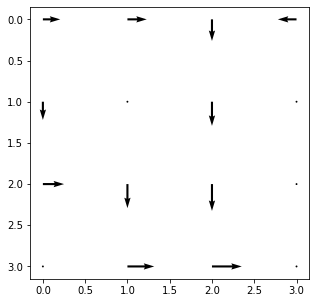

In [15]:
plotActionStateQuiver()

Text(0, 0.5, 'Average reward of an epoch')

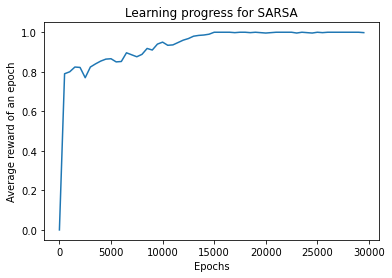

In [16]:
plt.plot(STEPS*np.arange(episodes//STEPS), performance)
plt.xlabel("Epochs")
plt.title("Learning progress for SARSA")
plt.ylabel("Average reward of an epoch")

In [17]:
greedyPolicyAvgPerf = average_performance(greedy_policy, q=q)
print("Greedy policy SARSA performance =", greedyPolicyAvgPerf) 

Greedy policy SARSA performance = 1.0


In [18]:
q = np.round(q,3)
print("(A,S) Value function =", q.shape)
print("First row")
print(q[0:4,:])
print("Second row")
print(q[4:8,:])
print("Third row")
print(q[8:12,:])
print("Fourth row")
print(q[12:16,:])

(A,S) Value function = (16, 4)
First row
[[0.501 0.498 0.583 0.512]
 [0.507 0.    0.649 0.567]
 [0.555 0.725 0.547 0.628]
 [0.627 0.25  0.514 0.516]]
Second row
[[0.507 0.611 0.001 0.45 ]
 [0.    0.    0.    0.   ]
 [0.    0.81  0.    0.629]
 [0.    0.    0.    0.   ]]
Third row
[[0.559 0.001 0.711 0.489]
 [0.557 0.807 0.655 0.001]
 [0.72  0.9   0.    0.662]
 [0.    0.    0.    0.   ]]
Fourth row
[[0.    0.    0.    0.   ]
 [0.01  0.766 0.9   0.681]
 [0.796 0.899 1.    0.792]
 [0.    0.    0.    0.   ]]


In [19]:
policyFound = [actionsDict[np.argmax(q[0,:])],actionsDict[np.argmax(q[1,:])],actionsDict[np.argmax(q[2,:])],actionsDict[np.argmax(q[3,:])],
               actionsDict[np.argmax(q[4,:])]," - ",actionsDict[np.argmax(q[6,:])]," - ",
               actionsDict[np.argmax(q[8,:])],actionsDict[np.argmax(q[9,:])],actionsDict[np.argmax(q[10,:])]," - ",
               " - ",actionsDict[np.argmax(q[13,:])],actionsDict[np.argmax(q[14,:])]," ! "]
print("Greedy policy found:")
idxs = [0,4,8,12]
for idx in idxs:
    print(policyFound[idx+0], policyFound[idx+1], 
          policyFound[idx+2], policyFound[idx+3])

print(" ")

print("Optimal policy:")
idxs = [0,4,8,12]
for idx in idxs:
    print(optimalPolicy[idx+0], optimalPolicy[idx+1], 
          optimalPolicy[idx+2], optimalPolicy[idx+3])

Greedy policy found:
 R   R   D   L 
 D   -   D   - 
 R   D   D   - 
 -   R   R   ! 
 
Optimal policy:
R/D  R   D   L 
 D   -   D   - 
 R  R/D  D   - 
 -   R   R   ! 
